# LV Weibo Analysis
## Author: Peiyu Xu
### Axiom Tech Consulting

#### Description:
Data is collected from LV China's Official Sina Weibo account.It includes all original weibo and repost weibo.

Main page:https://weibo.com/louisvuitton?topnav=1&wvr=6&topsug=1

Crawler credit to:https://github.com/dataabc/weiboSpider


## Analysis Plan
1. EDA for numerical variables [Finished]
2. Content anlysis [Finished]
   -  extract hashtags
   - extract @ (celebrities)
3. Transform Time variable [Finished]
4. Visualization / correlation among different numerical variables [Finished]
5. NLP
   - PKUSEG: Chinese words. segment 'content' 
   - NLTK: n-gram analysis, tf-idf
   - WordCloud

### Variables and descriptions
1. **weibo_id**: unique identifier for each microblog
2. **content**: microblog content, majorly Chinese text
3. **picture_url**: if the content has pictures attached, the picture_url is not null. 
4. **location**: the location of the microblog when being published
5. **time**: publish time, BJ time. Format: M/D/Y HH:MM
6. **tool**: publish tool. e.g. by Iphone APP
7. **up**: the number of "like" for a single microblog
8. **repost**: the number of repost for a single microblog
9. **comment**: the number of comments for a single microblog

Following variables are generated by analysis:

10. **hashtag**: in some microblogs, content will include #topic#. Will be extracted 
11. **hashtag_num**: how many topics are in a single microblog
12. **star**: in some mircoblogs, content will include @, which means mentioning other weibo users. Typically they are celebrities.
13. **star_num**: how many weibo users are mentioned in a single microblog.

In [171]:
# import packages
import pandas as pd
import jieba
import jieba.analyse
import matplotlib.pyplot as plt
import numpy as np
import chardet
from wordcloud import WordCloud,STOPWORDS
import thulac
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import re

In [142]:
# import LV_weibo.csv
data=pd.read_csv(r"LV_weibo.csv")
# dimensons
print(data.shape)

(2285, 9)


2,285 records and 9 columns

In [159]:
# check column names and data types
data.dtypes
#I've renamed column headers manually. In the crawler, headers are definded in Chinese. 
#You can change the headers using the following code.
#data.rename(columns={'微博id':'weibo_id','微博正文':'content','原始图片url':'pic_url','发布位置':'location','发布时间':'time','发布工具':'tool','点赞数':'up','转发数':'repost','评论数':'comment'},inplace=True)

weibo_id       object
content        object
picture_url    object
location       object
time           object
tool           object
up              int64
repost          int64
comment         int64
dtype: object

In [160]:
# head 5 records
data.head()

,weibo_id,content,picture_url,location,time,tool,up,repost,comment
0,HzlqJ9A6A,聆听时间齿轮运行之音，在#路易威登时间锦囊#成都展览见证精湛工艺的历久传承。品牌精心挑选数件...,http://ww2.sinaimg.cn/large/6d6f3290gy1g448qk3...,无,6/17/2019 18:30,微博 weibo.com,199,39,30
1,HzcoABt4A,路易威登 B Blossom 全新珠宝系列中，球面星形花卉灵感来源自 Monogram 印花...,http://ww4.sinaimg.cn/large/6d6f3290gy1g434d0o...,无,6/16/2019 19:30,微博 weibo.com,205,26,27
2,HyTlqdrWo,#路易威登时间锦囊#成都展览中的「魔力之箱」领域，呈现一段沉浸式品牌之旅。硬箱设计解构品牌标...,http://wx2.sinaimg.cn/large/6d6f3290gy1g40si7u...,无,6/14/2019 19:00,微博 weibo.com,147,16,13
3,HySX4eQNH,路易威登 LV RAINBOW 太阳眼镜，灵感来源 2019 春夏秀场的斑斓色彩，百搭设计开...,无,无,6/14/2019 18:00,微博 weibo.com,2311,1871,482
4,HyRbt907h,糅合经典元素，品牌创作专属贴纸，为#路易威登时间锦囊#成都展览增色。将这份纪念收入囊中，成为...,http://ww3.sinaimg.cn/large/6d6f3290gy1g40lgbv...,无,6/14/2019 13:30,微博 weibo.com,304,71,38


## Explortorary Data Analysis

In [155]:
# get summary statistics for numeric variables
data.describe()

,up,repost,comment
count,2285.000000,2285.000000,2285.000000
mean,967.557987,6121.360175,480.472210
std,6952.005086,58180.091735,3073.492308
min,0.000000,0.000000,0.000000
25%,18.000000,17.000000,12.000000
50%,125.000000,38.000000,25.000000
75%,270.000000,115.000000,65.000000
max,261983.000000,1000000.000000,56674.000000


Some outliers have been noticed.

In [156]:
# missing values
data.isnull().sum()

weibo_id       0
content        0
picture_url    0
location       0
time           0
tool           0
up             0
repost         0
comment        0
dtype: int64

In [157]:
# check pearson correlation
data.corr()

,up,repost,comment
up,1.000000,0.475995,0.791032
repost,0.475995,1.000000,0.724529
comment,0.791032,0.724529,1.000000


variable UP is highly correlated with variable COMMENT and REPOST.

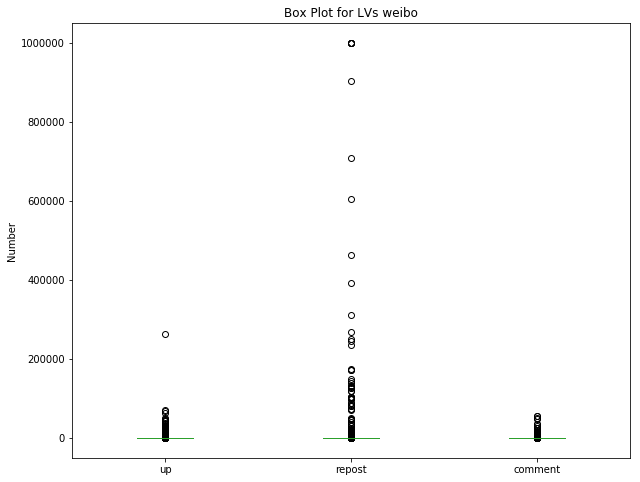

In [158]:
# vertical box plot
data[['up','repost','comment']].plot(kind='box', figsize=(10,8))
plt.title('Box Plot for LV''s weibo')
plt.ylabel('Number')
plt.show()

## Text Analysis

In [143]:
# a copy
df = data.copy()
print('copy finished')
df.shape

copy finished


(2285, 9)

### Using regular expression to extract hashtags and @ from content

In [ ]:
import re
df['hashtag'] = 0
for i in range(0, len(df['content'])):
    df['hashtag'][i] = re.findall('#([^\#|.]+)\#',df['content'][i])    

In [ ]:
# count the number of hashtags in content
df['hashtag_number'] = 0
for i in range(0,len(df['hashtag'])):
    df['hashtag_number'][i] = len(df['hashtag'][i])   

In [173]:
# stat for 'hashtag_number'
df['hashtag_number'].describe()

count    2285.000000
mean        0.561926
std         0.559306
min         0.000000
25%         0.000000
50%         1.000000
75%         1.000000
max         2.000000
Name: hashtag_number, dtype: float64

In [174]:
# frequency table for 'hashtag-number'
df['hashtag_number'].value_counts()

1    1132
0    1077
2      76
Name: hashtag_number, dtype: int64

In [ ]:
# extract @ information
# create a list called ['star']
df['star'] = 0
# please change the data type, otherwise will encounter "ValueError:setting an array element with a sequence. "
df['star'] = df['star'].astype('object',inplace=True)
# loop
for i in range(0, len(df['content'])):
    df['star'][i] = re.findall('@([^\s|\/|:|@]+)',df['content'][i])

In [ ]:
# count the number of "@" in content
df['star_number'] = 0
for i in range(0,len(df['star'])):
    df['star_number'][i] = len(df['star'][i])   
print('extract @ number finished')

In [175]:
# frequency table for 'star_number'
df['star_number'].value_counts()

0     1950
1      234
2       55
3       15
4        8
5        7
7        5
9        3
8        3
10       2
6        2
11       1
Name: star_number, dtype: int64

In [176]:
# stat for 'star_number'
df['star_number'].describe()

count    2285.000000
mean        0.256018
std         0.891493
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max        11.000000
Name: star_number, dtype: float64

## Extract Time information. Year, Month, Day, Hour

In [ ]:
df['year'] = 0
df['month'] = 0
df['day'] = 0
df['hour'] = 0
df['hour_h'] = 0 #added it on July1
df['hour_m'] = 0 #added it on July1
for i in range(0, df.shape[0]):
    df['year'][i] = df['time'][i].split(' ')[0].split('/')[2]
    df['month'][i] = df['time'][i].split(' ')[0].split('/')[0]
    df['day'][i] = df['time'][i].split(' ')[0].split('/')[1]
    df['hour'][i] = df['time'][i].split(' ')[1]
    df['hour_h'][i] = df['time'][i].split(' ')[1].split(':')[0] #added it on July1
    df['hour_m'][i] = df['time'][i].split(' ')[1].split(':')[1] #added it on July1

In [146]:
# convert time variables type
df['year'] = df['year'].astype('object')
df['month'] = df['month'].astype('object')
df['day'] = df['day'].astype('object')
df['hour']= df['hour'].astype('object')
df['hour_h'] = df['hour_h'].astype('object')
df['hour_m'] = df['hour_m'].astype('object') 

## More exploration on numeric variables

### Creating pivot tables

In [147]:
# year and other numerical variables
df_year_wb = df[['year','weibo_id']].groupby('year').count()
df_year_up = df[['year','up']].groupby('year').sum()
df_year_com = df[['year','comment']].groupby('year').sum()
df_year_rep = df[['year','repost']].groupby('year').sum()
df_year_hash = df[['year','hashtag_number']].groupby('year').sum()
df_year_star = df[['year','star_number']].groupby('year').sum()

In [148]:
# month and other numerical variables
# some might change to average for better interpretations
df_mon_wb = df[['month','weibo_id']].groupby('month').count()
df_mon_up = df[['month','up']].groupby('month').agg(np.mean)
df_mon_com = df[['month','comment']].groupby('month').agg(np.mean)
df_mon_rep = df[['month','repost']].groupby('month').agg(np.mean)
df_mon_hash = df[['month','hashtag_number']].groupby('month').agg(np.mean)
df_mon_star = df[['month','star_number']].groupby('month').agg(np.mean)

In [149]:
# day and other numerical variables
# some might change to average for better interpretations
df_day_wb = df[['day','weibo_id']].groupby('day').count()
df_day_up = df[['day','up']].groupby('day').agg(np.mean)
df_day_com = df[['day','comment']].groupby('day').agg(np.mean)
df_day_rep = df[['day','repost']].groupby('day').agg(np.mean)
df_day_hash = df[['day','hashtag_number']].groupby('day').agg(np.mean)
df_day_star = df[['day','star_number']].groupby('day').agg(np.mean)

In [150]:
# hour and other numerical variables
df_hr_wb = df[['hour_h','weibo_id']].groupby('hour_h').count()
df_hr_up = df[['hour_h','up']].groupby('hour_h').agg(np.mean)
df_hr_com = df[['hour_h','comment']].groupby('hour_h').agg(np.mean)
df_hr_rep = df[['hour_h','repost']].groupby('hour_h').agg(np.mean)
df_hr_hash = df[['hour_h','hashtag_number']].groupby('hour_h').agg(np.mean)
df_hr_star = df[['hour_h','star_number']].groupby('hour_h').agg(np.mean)

### Visualizations

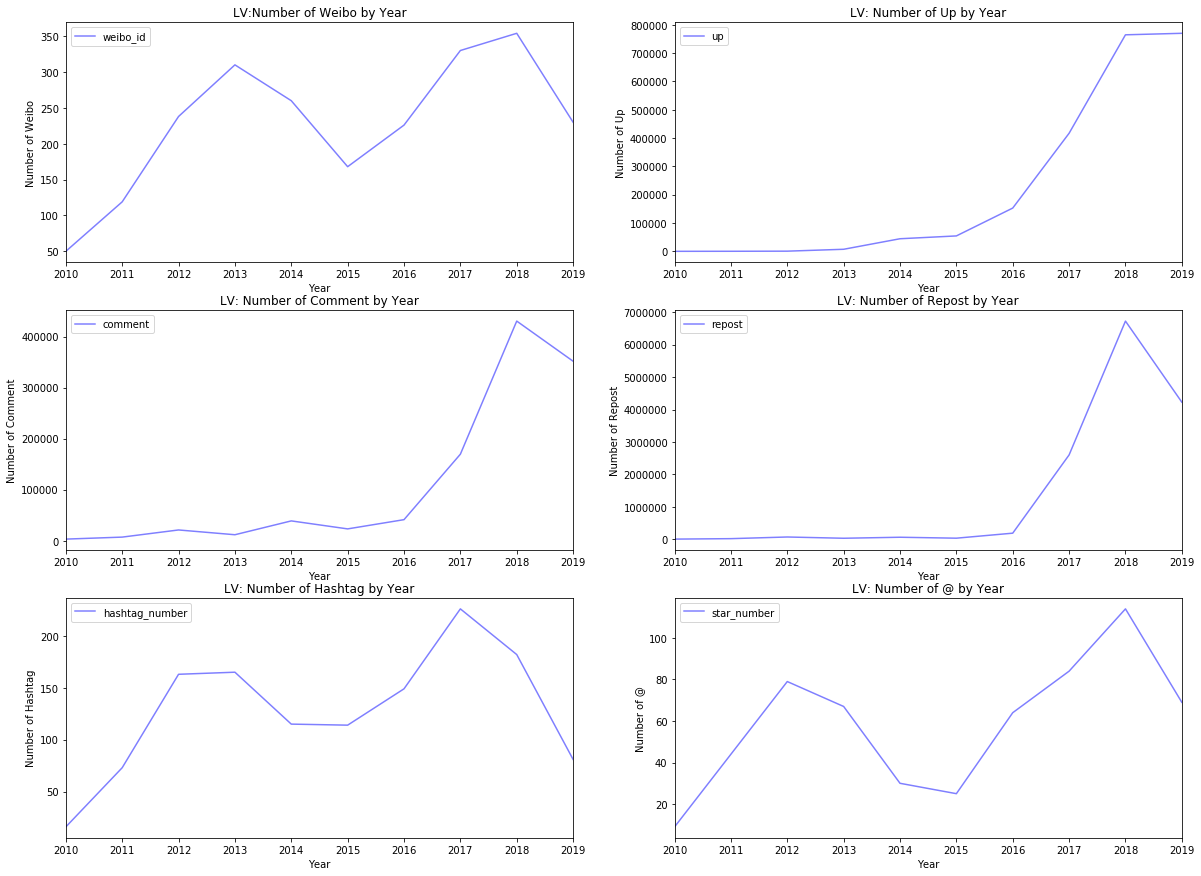

In [151]:
#weibo, #up, #comment, #repost by year
fig = plt.figure() # create figure

ax0 = fig.add_subplot(3, 2, 1) 
ax1 = fig.add_subplot(3, 2, 2) 
ax2 = fig.add_subplot(3, 2, 3)
ax3 = fig.add_subplot(3, 2, 4)
ax4 = fig.add_subplot(3, 2, 5)
ax5 = fig.add_subplot(3, 2, 6)
# Subplot 1: Bar plot for #weibo by year
df_year_wb.plot(kind='line', figsize=(20, 15), ax=ax0, color='blue', alpha=0.5) # add to subplot 1
ax0.set_title('LV:Number of Weibo by Year')
ax0.set_xlabel('Year')
ax0.set_ylabel('Number of Weibo')

# Subplot 2: Bar plot for #up by year
df_year_up.plot(kind='line', figsize=(20, 15), ax=ax1, color='blue', alpha=0.5) # add to subplot 2
ax1.set_title ('LV: Number of Up by Year')
ax1.set_ylabel('Number of Up')
ax1.set_xlabel('Year')

# Subplot 3: Bar plot for #comment by year
df_year_com.plot(kind='line', figsize=(20, 15), ax=ax2, color='blue', alpha=0.5) # add to subplot 3
ax2.set_title ('LV: Number of Comment by Year')
ax2.set_ylabel('Number of Comment')
ax2.set_xlabel('Year')

# Subplot 4: Bar plot for #repost by year
df_year_rep.plot(kind='line', figsize=(20, 15), ax=ax3, color='blue', alpha=0.5) # add to subplot 4
ax3.set_title ('LV: Number of Repost by Year')
ax3.set_ylabel('Number of Repost')
ax3.set_xlabel('Year')

# Subplot 5: Bar plot for #hashtag by year
df_year_hash.plot(kind='line', figsize=(20, 15), ax=ax4, color='blue', alpha=0.5) # add to subplot 5
ax4.set_title ('LV: Number of Hashtag by Year')
ax4.set_ylabel('Number of Hashtag')
ax4.set_xlabel('Year')

# Subplot 6: Bar plot for #mention by year
df_year_star.plot(kind='line', figsize=(20, 15), ax=ax5, color='blue', alpha=0.5) # add to subplot 6
ax5.set_title ('LV: Number of @ by Year')
ax5.set_ylabel('Number of @')
ax5.set_xlabel('Year')
plt.show()


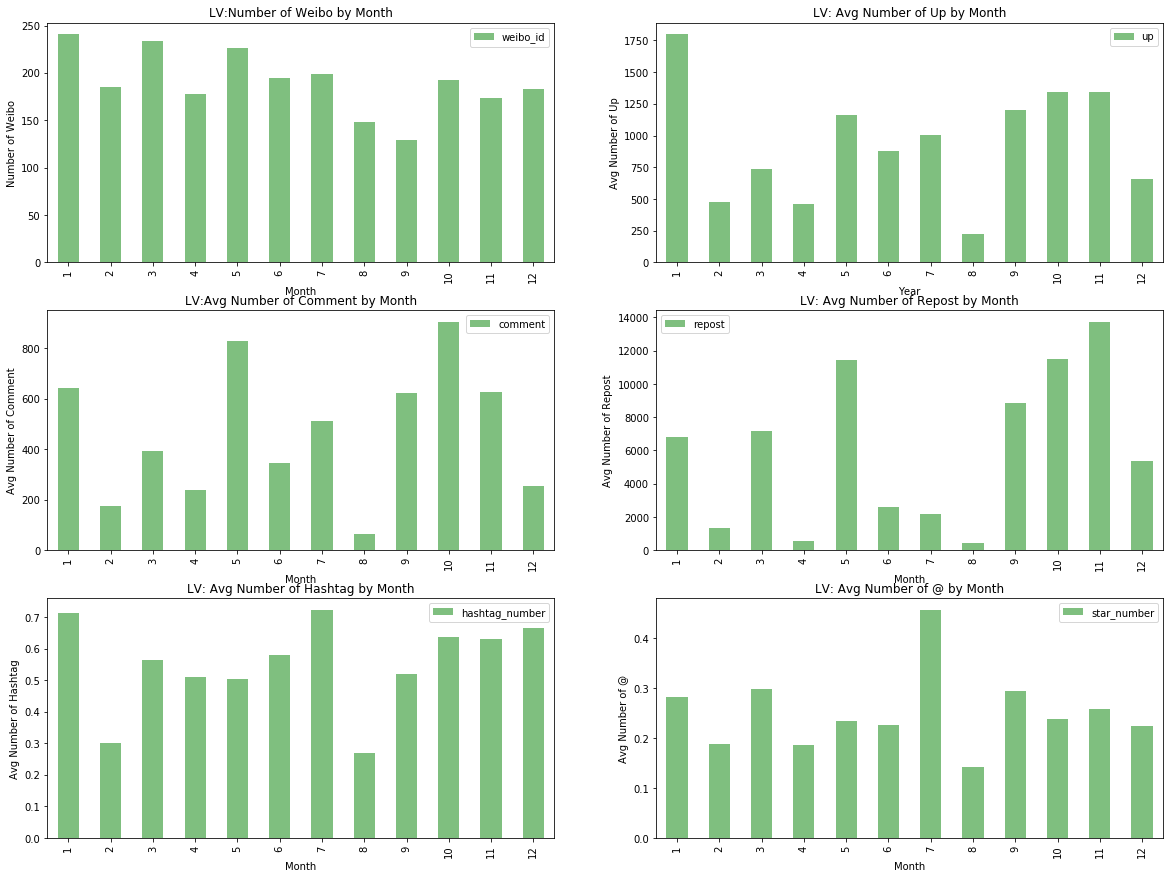

In [140]:
#weibo, avg#up, avg#comment, avg#repost, avg#hashtag, avg#@ by month
fig = plt.figure() # create figure

ax0 = fig.add_subplot(3, 2, 1) 
ax1 = fig.add_subplot(3, 2, 2) 
ax2 = fig.add_subplot(3, 2, 3)
ax3 = fig.add_subplot(3, 2, 4)
ax4 = fig.add_subplot(3, 2, 5)
ax5 = fig.add_subplot(3, 2, 6)
# Subplot 1: Bar plot for #weibo by month
df_mon_wb.plot(kind='bar', figsize=(20, 15), ax=ax0, color='green', alpha=0.5) # add to subplot 1
ax0.set_title('LV:Number of Weibo by Month')
ax0.set_xlabel('Month')
ax0.set_ylabel('Number of Weibo')

# Subplot 2: Bar plot for avg#up by month
df_mon_up.plot(kind='bar', figsize=(20, 15), ax=ax1, color='green', alpha=0.5) # add to subplot 2
ax1.set_title ('LV: Avg Number of Up by Month')
ax1.set_ylabel('Avg Number of Up')
ax1.set_xlabel('Year')

# Subplot 3: Bar plot for avg#comment by month
df_mon_com.plot(kind='bar', figsize=(20, 15), ax=ax2, color='green', alpha=0.5) # add to subplot 3
ax2.set_title ('LV:Avg Number of Comment by Month')
ax2.set_ylabel('Avg Number of Comment')
ax2.set_xlabel('Month')

# Subplot 4: Bar plot for avg#repost by month
df_mon_rep.plot(kind='bar', figsize=(20, 15), ax=ax3, color='green', alpha=0.5) # add to subplot 4
ax3.set_title ('LV: Avg Number of Repost by Month')
ax3.set_ylabel('Avg Number of Repost')
ax3.set_xlabel('Month')

# Subplot 5: Bar plot for avg#hashtag by month
df_mon_hash.plot(kind='bar', figsize=(20, 15), ax=ax4, color='green', alpha=0.5) # add to subplot 5
ax4.set_title ('LV: Avg Number of Hashtag by Month')
ax4.set_ylabel('Avg Number of Hashtag')
ax4.set_xlabel('Month')

# Subplot 6: Bar plot for avg#mention by month
df_mon_star.plot(kind='bar', figsize=(20, 15), ax=ax5, color='green', alpha=0.5) # add to subplot 6
ax5.set_title ('LV: Avg Number of @ by Month')
ax5.set_ylabel('Avg Number of @')
ax5.set_xlabel('Month')
plt.show()


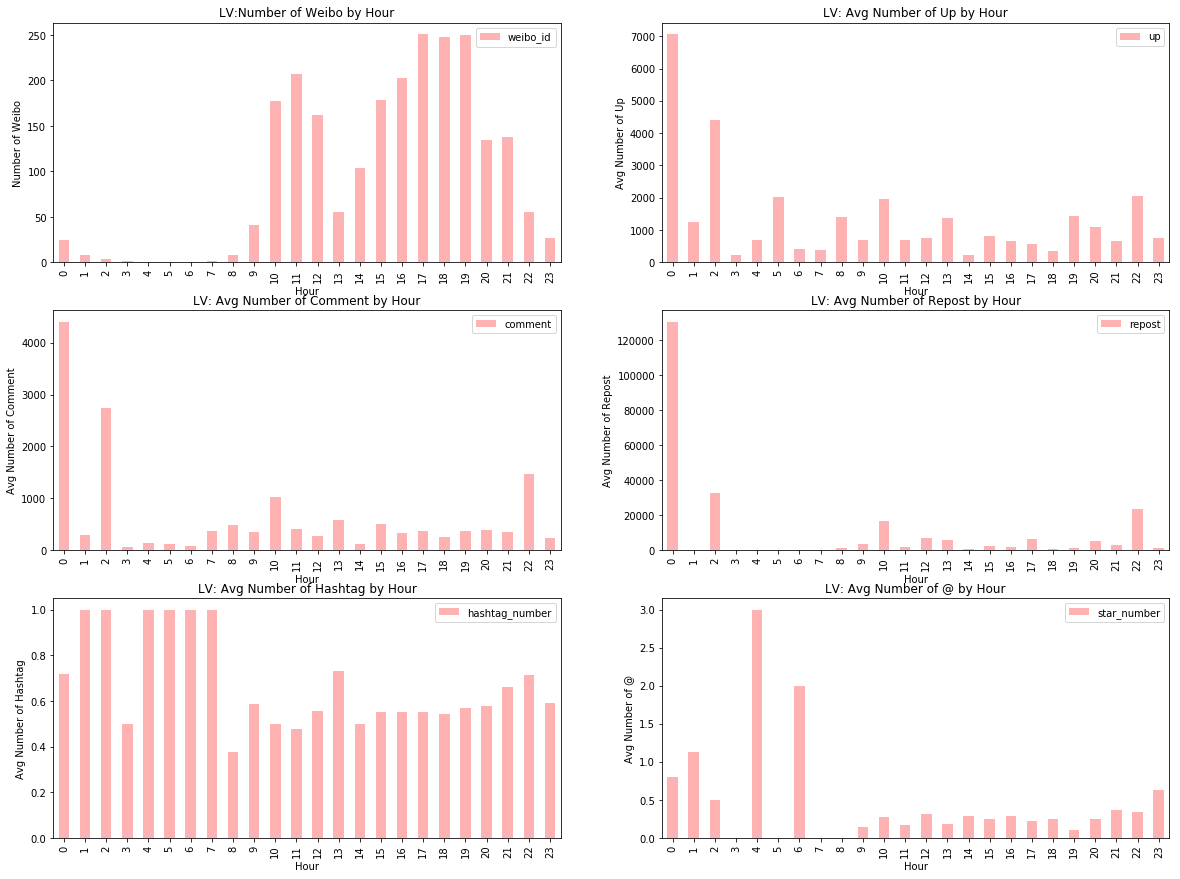

In [152]:
#weibo, avg#up, avg#comment, avg#repost, avg#hashtag, avg#@ by hour
fig = plt.figure() # create figure

ax0 = fig.add_subplot(3, 2, 1) 
ax1 = fig.add_subplot(3, 2, 2) 
ax2 = fig.add_subplot(3, 2, 3)
ax3 = fig.add_subplot(3, 2, 4)
ax4 = fig.add_subplot(3, 2, 5)
ax5 = fig.add_subplot(3, 2, 6)
# Subplot 1: Bar plot for #weibo by hour
df_hr_wb.plot(kind='bar', figsize=(20, 15), ax=ax0, color='red', alpha=0.3) # add to subplot 1
ax0.set_title('LV:Number of Weibo by Hour')
ax0.set_xlabel('Hour')
ax0.set_ylabel('Number of Weibo')

# Subplot 2: Bar plot for avg#up by hour
df_hr_up.plot(kind='bar', figsize=(20, 15), ax=ax1, color='red', alpha=0.3) # add to subplot 2
ax1.set_title ('LV: Avg Number of Up by Hour')
ax1.set_ylabel('Avg Number of Up')
ax1.set_xlabel('Hour')

# Subplot 3: Bar plot for avg#comment by hour
df_hr_com.plot(kind='bar', figsize=(20, 15), ax=ax2, color='red', alpha=0.3) # add to subplot 3
ax2.set_title ('LV: Avg Number of Comment by Hour')
ax2.set_ylabel('Avg Number of Comment')
ax2.set_xlabel('Hour')

# Subplot 4: Bar plot for avg#repost by hour
df_hr_rep.plot(kind='bar', figsize=(20, 15), ax=ax3, color='red', alpha=0.3) # add to subplot 4
ax3.set_title ('LV: Avg Number of Repost by Hour')
ax3.set_ylabel('Avg Number of Repost')
ax3.set_xlabel('Hour')

# Subplot 5: Bar plot for avg#hashtag by hour
df_hr_hash.plot(kind='bar', figsize=(20, 15), ax=ax4, color='red', alpha=0.3) # add to subplot 2
ax4.set_title ('LV: Avg Number of Hashtag by Hour')
ax4.set_ylabel('Avg Number of Hashtag')
ax4.set_xlabel('Hour')

# Subplot 6: Bar plot for avg#mention by hour
df_hr_star.plot(kind='bar', figsize=(20, 15), ax=ax5, color='red', alpha=0.3) # add to subplot 2
ax5.set_title ('LV: Avg Number of @ by Hour')
ax5.set_ylabel('Avg Number of @')
ax5.set_xlabel('Hour')
plt.show()


### Explore weibo data in 2017, 2018 and 2019 Jan-June
since LV's weibo became popular since 2016.

In [203]:
# histogram of weibo 
# create sub dataframes
df_2017 = df.query('year==2017')
df_2018 = df.query('year==2018')
df_2019 = df.query('year==2019')
print('the number of microblogs in year 2017:',df_2017.shape[0])
print('the number of microblogs in year 2018:',df_2018.shape[0])
print('the number of microblogs in year 2019 from Jan-June:',df_2019.shape[0])

the number of microblogs in year 2017: 330
the number of microblogs in year 2018: 354
the number of microblogs in year 2019 from Jan-June: 230


#### Histogram for 2017

Text(0, 0.5, 'frequency')

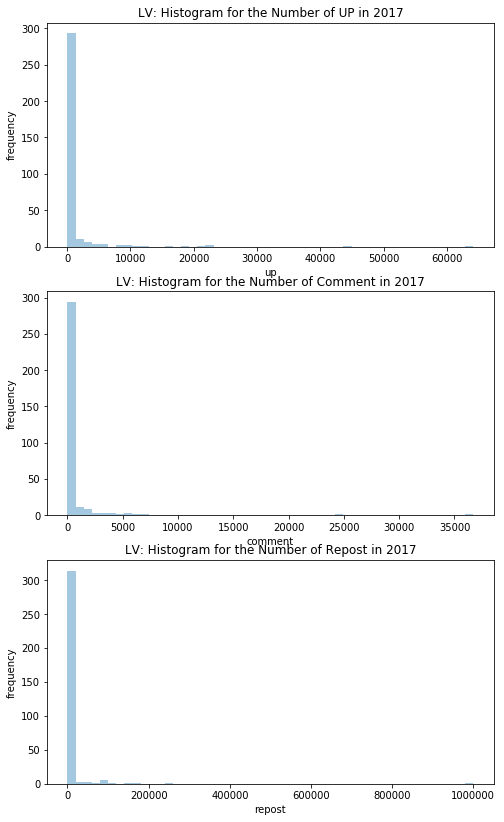

In [209]:
#histogram for 2017
fig = plt.figure( figsize=(8, 14))
ax6 = fig.add_subplot(3 ,1, 1)
ax7 = fig.add_subplot(3, 1, 2)
ax8 = fig.add_subplot(3, 1, 3)

# Subplot 1: histogram for "up" in 2017
sns.distplot(df_2017['up'], ax =ax6, norm_hist = False, kde = False)
ax6.set_title('LV: Histogram for the Number of UP in 2017')
ax6.set_ylabel('frequency')
# Subplot 2: histogram for "comment" in 2017
sns.distplot(df_2017['comment'], ax = ax7, norm_hist = False, kde = False)
ax7.set_title('LV: Histogram for the Number of Comment in 2017')
ax7.set_ylabel('frequency')
# Subplot 1: histogram for "repost" in 2017
sns.distplot(df_2017['repost'], ax = ax8, norm_hist = False, kde = False)
ax8.set_title('LV: Histogram for the Number of Repost in 2017')
ax8.set_ylabel('frequency')

#### Histogram for 2018

Text(0, 0.5, 'frequency')

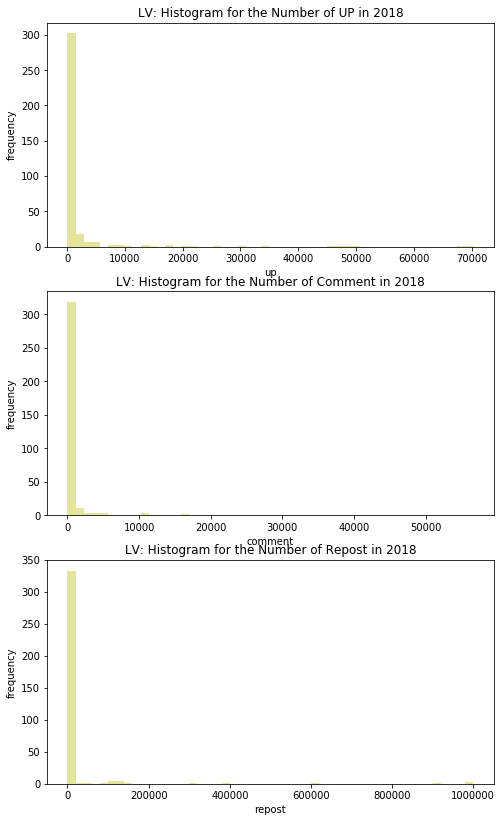

In [210]:
#histogram for 2018
fig = plt.figure( figsize=(8, 14))
ax6 = fig.add_subplot(3 ,1, 1)
ax7 = fig.add_subplot(3, 1, 2)
ax8 = fig.add_subplot(3, 1, 3)

# Subplot 1: histogram for "up" in 2018
sns.distplot(df_2018['up'], ax = ax6, norm_hist = False, kde = False, color='y')
ax6.set_title('LV: Histogram for the Number of UP in 2018')
ax6.set_ylabel('frequency')
# Subplot 2: histogram for "comment" in 2018
sns.distplot(df_2018['comment'], ax = ax7, norm_hist = False, kde = False, color='y')
ax7.set_title('LV: Histogram for the Number of Comment in 2018')
ax7.set_ylabel('frequency')
# Subplot 1: histogram for "repost" in 2018
sns.distplot(df_2018['repost'], ax = ax8, norm_hist = False, kde = False, color='y')
ax8.set_title('LV: Histogram for the Number of Repost in 2018')
ax8.set_ylabel('frequency')

#### Histogram for 2019

Text(0, 0.5, 'frequency')

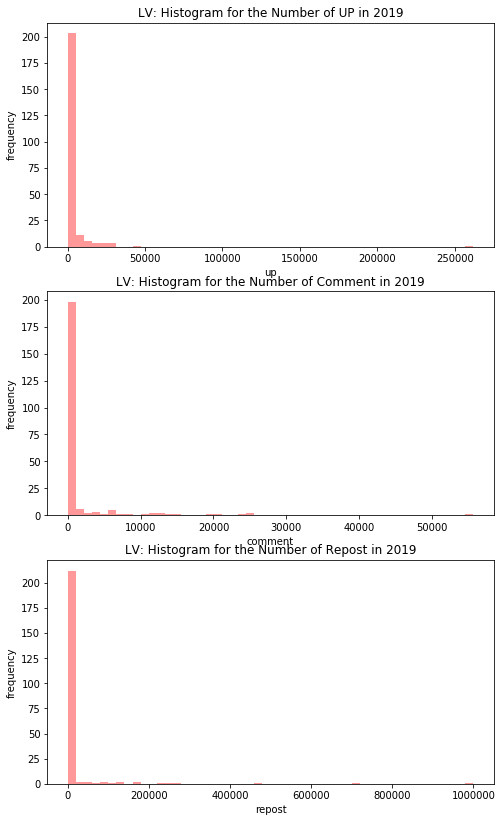

In [212]:
#histogram for 2019
fig = plt.figure( figsize=(8, 14))
ax6 = fig.add_subplot(3 ,1, 1)
ax7 = fig.add_subplot(3, 1, 2)
ax8 = fig.add_subplot(3, 1, 3)

# Subplot 1: histogram for "up" in 2019
sns.distplot(df_2019['up'], ax = ax6, norm_hist = False, kde = False, color='r')
ax6.set_title('LV: Histogram for the Number of UP in 2019')
ax6.set_ylabel('frequency')
# Subplot 2: histogram for "comment" in 2019
sns.distplot(df_2019['comment'], ax = ax7, norm_hist = False, kde = False, color='r')
ax7.set_title('LV: Histogram for the Number of Comment in 2019')
ax7.set_ylabel('frequency')
# Subplot 1: histogram for "repost" in 2019
sns.distplot(df_2019['repost'], ax = ax8, norm_hist = False, kde = False, color='r')
ax8.set_title('LV: Histogram for the Number of Repost in 2019')
ax8.set_ylabel('frequency')

### hashtag number - visualizations

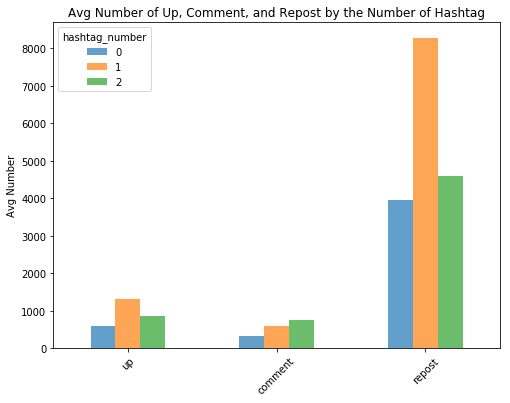

In [153]:
# hashtag number - visualizations
df_hash = df[['hashtag_number','up','comment','repost']].groupby('hashtag_number').agg(np.mean)
df_hash_T = df_hash.T
df_hash_T.plot(kind='bar',figsize = (8,6), alpha= 0.7)
plt.ylabel('Avg Number')
plt.xticks(rotation=45)
plt.title('Avg Number of Up, Comment, and Repost by the Number of Hashtag')
plt.show()

### @ number - visualizations

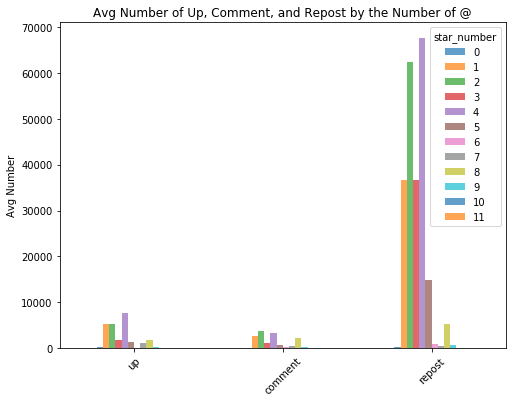

In [154]:
# @ number - visualizations
df_star = df[['star_number','up','comment','repost']].groupby('star_number').agg(np.mean)
df_star_T = df_star.T
df_star_T.plot(kind='bar',figsize = (8,6), alpha = 0.7)
plt.title('Avg Number of Up, Comment, and Repost by the Number of @')
plt.ylabel('Avg Number')
plt.xticks(rotation=45)
plt.show()

In [161]:
df.to_csv('lv_july1.csv',index=False)

### Box plot for 2017, 2018 and 2019

Text(0.5, 1.0, 'Box plot for 2019')

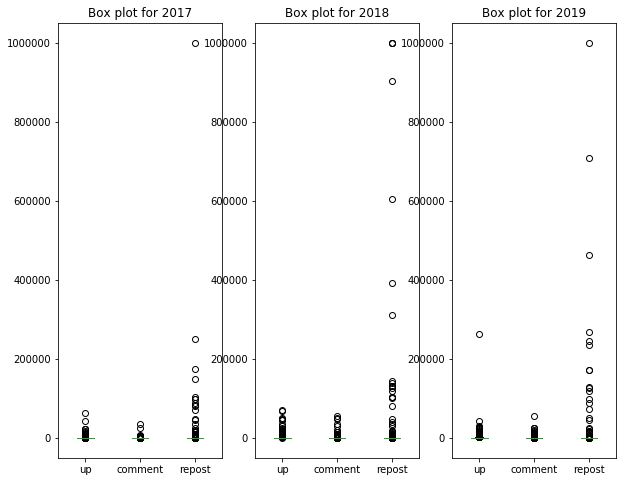

In [234]:
fig = plt.figure(figsize=(8, 14))
ax9 = fig.add_subplot(1 ,3, 1)
ax10 = fig.add_subplot(1 ,3, 2)
ax11 = fig.add_subplot(1 ,3, 3)

df_2017[['up','comment','repost']].plot(kind='box', figsize= (10,8), ax = ax9)
ax9.set_title('Box plot for 2017')

df_2018[['up','comment','repost']].plot(kind='box', figsize= (10,8), ax = ax10)
ax10.set_title('Box plot for 2018')

df_2019[['up','comment','repost']].plot(kind='box', figsize= (10,8), ax = ax11)
ax11.set_title('Box plot for 2019')

# In Progress
1. 指定条件，选择合适的weibo_id进行评论研究
条件范例：评论数高于90 percentile
2. 指定weibo_id，爬取评论做文本分析

In [236]:
df.corr()

,up,repost,comment,hashtag_number,star_number
up,1.000000,0.475995,0.791032,0.042838,0.123060
repost,0.475995,1.000000,0.724529,0.029750,0.138307
comment,0.791032,0.724529,1.000000,0.044937,0.162726
hashtag_number,0.042838,0.029750,0.044937,1.000000,0.077512
star_number,0.123060,0.138307,0.162726,0.077512,1.000000


In [238]:
np.percentile(df_2017['comment'],90)

957.5000000000022

In [239]:
df_2017_90 = df_2017.query('comment>=957')
print(df_2017_90.shape[0])

33


In [240]:
df_2017_90

,weibo_id,content,picture_url,location,time,tool,up,repost,comment,hashtag,hashtag_number,star,star_number,year,month,day,hour,hour_h,hour_m
603,FyzjPdiYX,节日悄然而至，与@钟楚曦 、@许魏洲zz 一同前往路易威登奇妙礼品世界，为你的Ta选购心仪之...,http://ww4.sinaimg.cn/large/6d6f3290gy1fm6u095...,无,12/7/2017 18:32,微博 weibo.com,3382,4120,1245,[],0,"['钟楚曦', '许魏洲zz']",2,2017,12,7,18:32,18,32
604,FydXQ56Lg,@许魏洲zz 的节日愿望清单为时髦男士提供更多造型灵感。Josh双肩包简约精干，是都市型男...,http://ww2.sinaimg.cn/large/6d6f3290gy1fm5rk1m...,无,12/5/2017 12:10,微博 weibo.com,4091,19264,1824,['路易威登礼品工坊'],1,['许魏洲zz'],1,2017,12,5,12:10,12,10
606,Fy9bf535v,欢迎来到路易威登奇妙礼品世界，与@钟楚曦 、@许魏洲zz 共同开启节日双重奏 http://...,无,无,12/5/2017 0:00,微博 weibo.com,18587,249524,4177,['路易威登礼品工坊'],1,"['钟楚曦', '许魏洲zz']",2,2017,12,5,0:00,0,0
622,FuaTh7w1b,@Crystal张天爱 的大师系列-透纳。http://t.cn/RlYnJo3 #路易威...,http://wx4.sinaimg.cn/large/6d6f3290gy1flauwol...,无,11/8/2017 21:00,微博 weibo.com,1326,3911,1282,['路易威登与JeffKoons'],1,['Crystal张天爱'],1,2017,11,8,21:00,21,0
624,Fua6zf1c7,@唐嫣 的大师系列-莫奈。http://t.cn/RlYPezX #路易威登与JeffKoo...,http://wx4.sinaimg.cn/large/6d6f3290gy1flarmio...,无,11/8/2017 19:00,微博 weibo.com,1271,6543,1043,['路易威登与JeffKoons'],1,['唐嫣'],1,2017,11,8,19:00,19,0
625,Fu9kWDLW6,@李晨 的大师系列-莫奈。 http://t.cn/RljJVui #路易威登与JeffKo...,http://wx2.sinaimg.cn/large/6d6f3290gy1flasaye...,无,11/8/2017 17:02,微博 weibo.com,827,4954,2786,['路易威登与JeffKoons'],1,['李晨'],1,2017,11,8,17:02,17,2
627,Fu7Gn2Bg4,@TFBOYS-王源 的大师系列-莫奈。http://t.cn/Rllvcuv #路易威登与...,http://wx3.sinaimg.cn/large/6d6f3290gy1flal02s...,无,11/8/2017 12:50,微博 weibo.com,9049,1000000,5264,['路易威登与JeffKoons'],1,['TFBOYS-王源'],1,2017,11,8,12:50,12,50
680,FmHfWdAsW,我们承诺##MAKEAPROMISE#与@唐嫣 @刘江 @Ming奚梦瑶 @陈学冬 @许魏洲...,http://ww2.sinaimg.cn/large/6d6f3290gy1fjq3sy6...,无,9/20/2017 16:41,微博 weibo.com,5425,15409,6406,['MAKEAPROMISE'],1,"['唐嫣', '刘江', 'Ming奚梦瑶', '陈学冬', '许魏洲ZZ', '苏芒', ...",8,2017,9,20,16:41,16,41
706,FgaMSBot0,@许魏洲ZZ 身着路易威登17秋冬男士系列成衣登上 @风度mensuno 封面，整体造型完美...,http://ww4.sinaimg.cn/large/6d6f3290gy1fich4lg...,无,8/8/2017 19:00,微博 weibo.com,8569,47181,1534,[],0,"['许魏洲ZZ', '风度mensuno']",2,2017,8,8,19:00,19,0
715,Fe03rxZWt,为您呈现鹿晗@M鹿M 于路易威登 Tambour Horizon 智能腕表《向时间致敬》影片...,http://ww1.sinaimg.cn/large/6d6f3290gy1fhvz8nu...,无,7/25/2017 12:00,微博 weibo.com,21682,36529,7133,['路易威登触动之旅'],1,['M鹿M'],1,2017,7,25,12:00,12,0


# NLP-In progress

## Chinese words: Use PKUSEG

In [ ]:
pkumodel = pkuseg.pkuseg(model_name = "web", user_dict = "default", postag = False)
df['content_cut'] = 0
for i in range(0,df.shape[0]):
    df['content_cut'][i] = pkumodel.cut(df['content'][i])

In [ ]:
content_list = df['content_cut'].tolist()
content_split = " ".join(content_list)

In [ ]:
from wordcloud import WordCloud
font_path = "shujian.ttf"
lv_wc = WordCloud(scale=4, font_path=font_path, background_color='white',
                       max_words=1000, max_font_size=55, random_state=24).generate(content_list)
plt.imshow(my_wordcloud)
plt.axis('off')
plt.show()

In [ ]:
with open('lv_content.txt', 'w') as file:  
    for item in content_list:
        file.write('%s\n' % item)

In [177]:
import jieba

for line in :
    seg = pkumodel.cut(df['content'][i])
    output ='/'.join(seg) 
    s = ('lv_content.txt','a+')
    s.write(output)


SyntaxError: invalid syntax (<ipython-input-177-5d1076c1eb56>, line 3)